# Bio-informatics project

BONTEMPI ALESSANDRA

## STEP 1: data analysis and processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from pydeseq2.dds import DeseqDataSet
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import networkx as nx
from sklearn.cluster import KMeans
from pydeseq2.ds import DeseqStats
import gseapy as gp

In [3]:
data = pd.read_excel("RawData.xlsx")

In [4]:
data.head()

,geneID,Description,geneName,EntrezID,EntrezIDs,K12,K13,K14,K16,K17,...,MICT1,MICT10,MICT10-2,MICT16,MICT17,MICT18,MICT19,MICT26,MICT26-2,MICT5
0,ENSG00000000003,tetraspanin 6,TSPAN6,7105.0,7105,14,13,19,12,9,...,11,28,15,16,15,7,30,18,11,20
1,ENSG00000000005,tenomodulin,TNMD,64102.0,64102,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000000419,dolichyl-phosphate mannosyltransferase subunit...,DPM1,8813.0,8813,410,568,592,461,457,...,485,525,503,562,615,516,671,601,626,560
3,ENSG00000000457,SCY1 like pseudokinase 3,SCYL3,57147.0,57147,401,447,399,416,435,...,399,418,441,436,374,340,328,405,359,381
4,ENSG00000000460,chromosome 1 open reading frame 112,C1orf112,55732.0,55732,108,110,75,97,95,...,129,123,140,82,57,60,60,85,96,81


In this section, we will:
1. visualize the sample by creating plots and normalize the data (I will be using variance stabilization).
2. filter lowly expressed genes. For this, I need to define a threshold and remove genes with negligible expression, because they are unlikely to be informative and can add noise to our analysis. To do find the threshold, I will use a GMM on both mean and variance.
3. I will use PCA to see if there are clusters.

In [5]:
# the metadata is the information describing the characteristics of each gene or sample, which provides context for the expression values.
# (for us it's: gene IDs, gene symbols, descriptions, sample labels)
metadata_cols = ['geneID', 'Description', 'geneName', 'EntrezID', 'EntrezIDs']
metadata = data[metadata_cols]

In [6]:
metadata.head()

,geneID,Description,geneName,EntrezID,EntrezIDs
0,ENSG00000000003,tetraspanin 6,TSPAN6,7105.0,7105
1,ENSG00000000005,tenomodulin,TNMD,64102.0,64102
2,ENSG00000000419,dolichyl-phosphate mannosyltransferase subunit...,DPM1,8813.0,8813
3,ENSG00000000457,SCY1 like pseudokinase 3,SCYL3,57147.0,57147
4,ENSG00000000460,chromosome 1 open reading frame 112,C1orf112,55732.0,55732


In [ ]:
# instead, expression data is the numeric values (raw read counts) that indicate the level of gene expression across different samples or conditions.
expression = data.drop(columns = metadata_cols)

In [8]:
expression.head()

,K12,K13,K14,K16,K17,K18,K2,K20,K3,K5,...,MICT1,MICT10,MICT10-2,MICT16,MICT17,MICT18,MICT19,MICT26,MICT26-2,MICT5
0,14,13,19,12,9,10,7,16,19,29,...,11,28,15,16,15,7,30,18,11,20
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,410,568,592,461,457,517,438,542,470,533,...,485,525,503,562,615,516,671,601,626,560
3,401,447,399,416,435,412,325,409,440,468,...,399,418,441,436,374,340,328,405,359,381
4,108,110,75,97,95,121,97,108,104,75,...,129,123,140,82,57,60,60,85,96,81


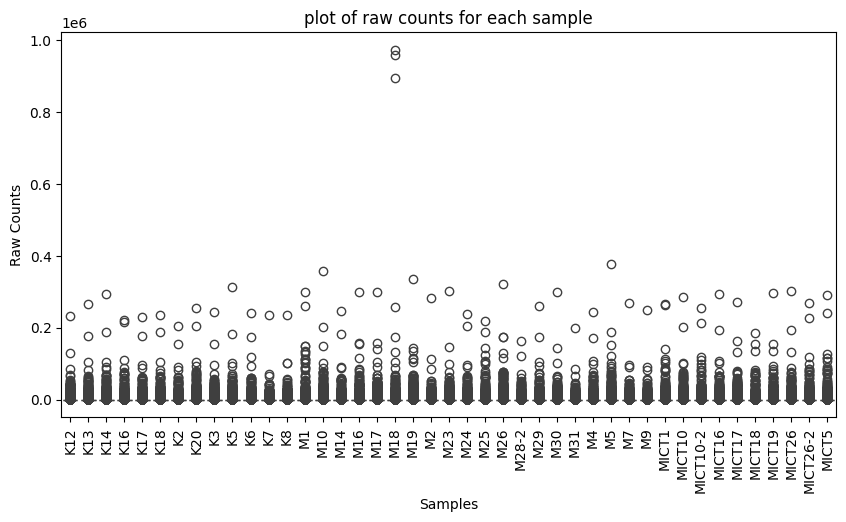

In [9]:
plt.figure(figsize = (10, 5))
sns.boxplot(data = expression)
plt.xticks(rotation = 90)
plt.xlabel('Samples')
plt.ylabel('Raw Counts')
plt.title('plot of raw counts for each sample')
plt.show()

In [10]:
expression.describe()

,K12,K13,K14,K16,K17,K18,K2,K20,K3,K5,...,MICT1,MICT10,MICT10-2,MICT16,MICT17,MICT18,MICT19,MICT26,MICT26-2,MICT5
count,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,...,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000,22625.000000
mean,590.169105,640.520177,642.145503,644.316066,630.895779,637.326055,540.980376,660.129591,603.333348,619.369370,...,642.293702,636.345414,615.958939,646.975028,656.644155,599.290652,612.454320,645.746785,643.312486,663.266829
std,2791.337206,3177.956959,3454.386293,3217.938115,3010.408992,3092.217329,2705.798159,3408.483547,2912.102896,3450.124431,...,3742.586281,3474.305375,3449.669975,3462.335009,3324.234646,2979.393252,3484.380313,3572.454928,3569.650307,3896.741134
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,44.000000,42.000000,43.000000,45.000000,44.000000,35.000000,43.000000,42.000000,38.000000,...,42.000000,44.000000,41.000000,44.000000,42.000000,42.000000,40.000000,42.000000,41.000000,42.000000
75%,482.000000,537.000000,526.000000,523.000000,520.000000,524.000000,435.000000,528.000000,502.000000,491.000000,...,513.000000,510.000000,473.000000,527.000000,525.000000,483.000000,479.000000,504.000000,511.000000,505.000000
max,231833.000000,266124.000000,293386.000000,221393.000000,229686.000000,236754.000000,204914.000000,256127.000000,243293.000000,313702.000000,...,266318.000000,286270.000000,253932.000000,295256.000000,271528.000000,186219.000000,297880.000000,303670.000000,269839.000000,291157.000000


For every sample, the total number of genes is 22,625. However, most genes in each sample tend to have low or zero counts (as indicated by the median and 25th percentile being low or zero), while a small proportion of genes are expressed at very high levels (reflected by the high max values). This is to be expected as we are working with bulk RNA-seq data.

### VARIANCE STABILIZATION

In [ ]:
counts = expression.T.copy().astype(int)
l = ['K'] * 13 + ['M'] * 20 + ['MICT'] * 10
colData = pd.DataFrame({'condition': l}, index = counts.index)
dds = DeseqDataSet(counts = counts, metadata = colData, design = 'condition')
dds.deseq2()
dds.vst(use_design = False, fit_type = None)
vst_array = dds.vst_transform()

# NOTE: the below cell presents "\Users\Piercarlo\...". This is because to run the code, a different computer was used due to problems with my own pc.

c:\Users\Piercarlo\Desktop\tesi ale\tesi\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Fitting size factors...
... done in 0.08 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 4.23 seconds.

Fitting dispersion trend curve...
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 5.40 seconds.

Fitting LFCs...
... done in 2.38 seconds.

Calculating cook's distance...
... done in 0.09 seconds.

Replacing 56 outlier genes.

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.03 seconds.



Fit type used for VST : parametric


Fitting dispersions...
... done in 4.12 seconds.



In [12]:
vst_df = pd.DataFrame(vst_array.T, index = expression.index, columns = expression.columns)
print("VST matrix shape:", vst_df.shape)
vst_df.head()

VST matrix shape: (22625, 43)


,K12,K13,K14,K16,K17,K18,K2,K20,K3,K5,...,MICT1,MICT10,MICT10-2,MICT16,MICT17,MICT18,MICT19,MICT26,MICT26-2,MICT5
0,4.977430,4.860496,5.147790,4.816079,4.643453,4.704315,4.610304,5.013585,5.170550,5.544991,...,4.780394,5.478404,5.047154,5.018623,4.983871,4.565985,5.618954,5.141436,4.791191,5.217014
1,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016,...,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016,3.447016
2,8.700161,9.013335,9.106252,8.741462,8.730370,8.899623,8.936051,8.970653,8.828467,9.037889,...,8.852911,8.961591,9.021025,9.030486,9.177041,9.049660,9.424405,9.190695,9.230017,9.081746
3,8.669793,8.683730,8.563756,8.601003,8.662838,8.588383,8.527170,8.584222,8.737907,8.858374,...,8.585542,8.648461,8.839551,8.681132,8.493284,8.477487,8.437826,8.646506,8.465384,8.552496
4,6.962864,6.866518,6.451858,6.730869,6.707181,6.995584,6.960602,6.863679,6.865626,6.514684,...,7.110607,7.051629,7.318827,6.549867,6.165950,6.311498,6.318815,6.646943,6.774787,6.582280


### GMM

Now, we drop low expressed genes to reduce noise using GMM.

In [ ]:
gene_means = vst_df.mean(axis = 1)
gene_vars  = vst_df.var(axis = 1)

In [ ]:
def dropper(series, steps = 10000, random_state = 42):
    values = series.values.reshape(-1, 1)
    gmm = GaussianMixture(n_components = 2, covariance_type = 'full', random_state = random_state)
    gmm.fit(values)
    
    mus, sigmas, weights = gmm.means_.flatten(), np.sqrt(gmm.covariances_.reshape(2)), gmm.weights_.flatten()
    i, j = np.argsort(mus)
    mu1, mu2 = mus[i], mus[j]
    s1, s2 = sigmas[i], sigmas[j]
    w1, w2 = weights[i], weights[j]
    
    grid = np.linspace(mu1, mu2, steps)
    pdf1 = w1 * norm.pdf(grid, mu1, s1)
    pdf2 = w2 * norm.pdf(grid, mu2, s2)
    
    return grid[np.argmin(np.abs(pdf1 - pdf2))]

In [ ]:
mean_threshold = dropper(gene_means)
var_threshold = dropper(gene_vars)
print("Mean threshold:", mean_threshold)
print("Variance threshold:", var_threshold)

Mean threshold: 3.508211637351299
Variance threshold: 0.23967360142852218


In [16]:
mask = (gene_means >= mean_threshold) & (gene_vars >= var_threshold)
filtered = vst_df.loc[mask]
print(f"Kept {filtered.shape[0]} / {vst_df.shape[0]} genes")

Kept 1461 / 22625 genes


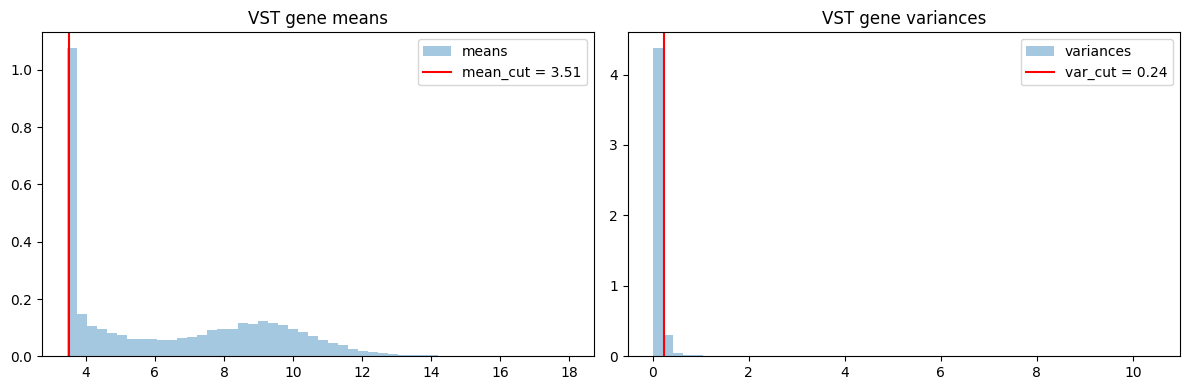

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (12,4))
axes[0].hist(gene_means, bins = 50, density = True, alpha = 0.4, label = 'means')
axes[0].axvline(mean_threshold, color = 'r', label = f'mean_cut = {mean_threshold:.2f}')
axes[0].set_title('VST gene means') 
axes[0].legend()
axes[1].hist(gene_vars, bins = 50, density = True, alpha = 0.4, label = 'variances')
axes[1].axvline(var_threshold, color = 'r', label = f'var_cut = {var_threshold:.2f}')
axes[1].set_title('VST gene variances'); axes[1].legend()
plt.tight_layout()
plt.show()

### PCA

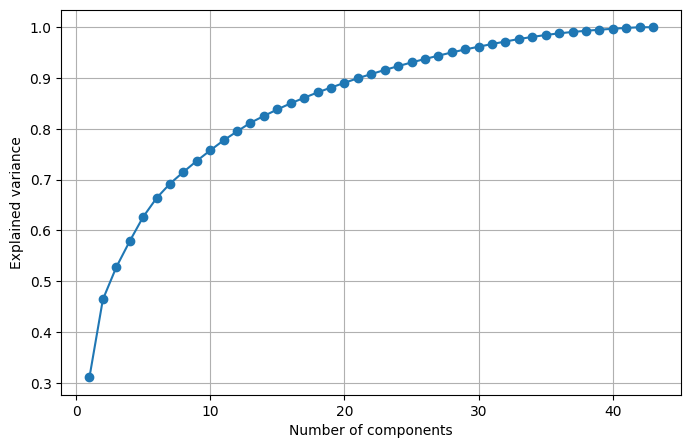

In [ ]:
X = StandardScaler(with_mean = True, with_std = False).fit_transform(filtered.T)
pca_full = PCA().fit(X)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize = (8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker = 'o')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.grid(True)
plt.show()

In [ ]:
# i chose 15 components based on the plot above because it seems like 15 components explain more or less 85% of the variance
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(X_pca, index = filtered.columns, columns = [f'PC{i + 1}' for i in range(X_pca.shape[1])])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
K12,-9.812893,-1.487259,7.921332,3.253219,-4.820651,0.843549,5.690316,-2.627933,4.362570,5.579353,-1.952378,-1.040935,-4.817444,-0.638379,0.808694
K13,-14.069893,-1.301132,-1.391416,-1.187935,1.224511,-2.309359,-2.565167,0.161830,2.521059,-3.399473,3.622715,-1.103380,-4.061819,1.642999,-3.540141
K14,-10.669368,-5.632446,3.367579,-6.313559,1.361498,-0.825385,-2.842624,-4.467031,1.339258,-1.764105,-1.876426,1.419309,-1.876781,-4.135062,-5.223555
K16,-13.049974,0.888545,3.628199,5.251574,1.871074,-4.500724,-4.304472,-4.964058,2.637220,1.814017,-2.485786,0.151439,0.745990,-2.423898,0.091444
K17,-13.526597,7.865624,0.193383,4.259561,2.756096,-0.467755,-8.724327,-5.378993,3.137222,1.824674,-0.936589,0.091973,0.937448,-0.542570,-3.568601


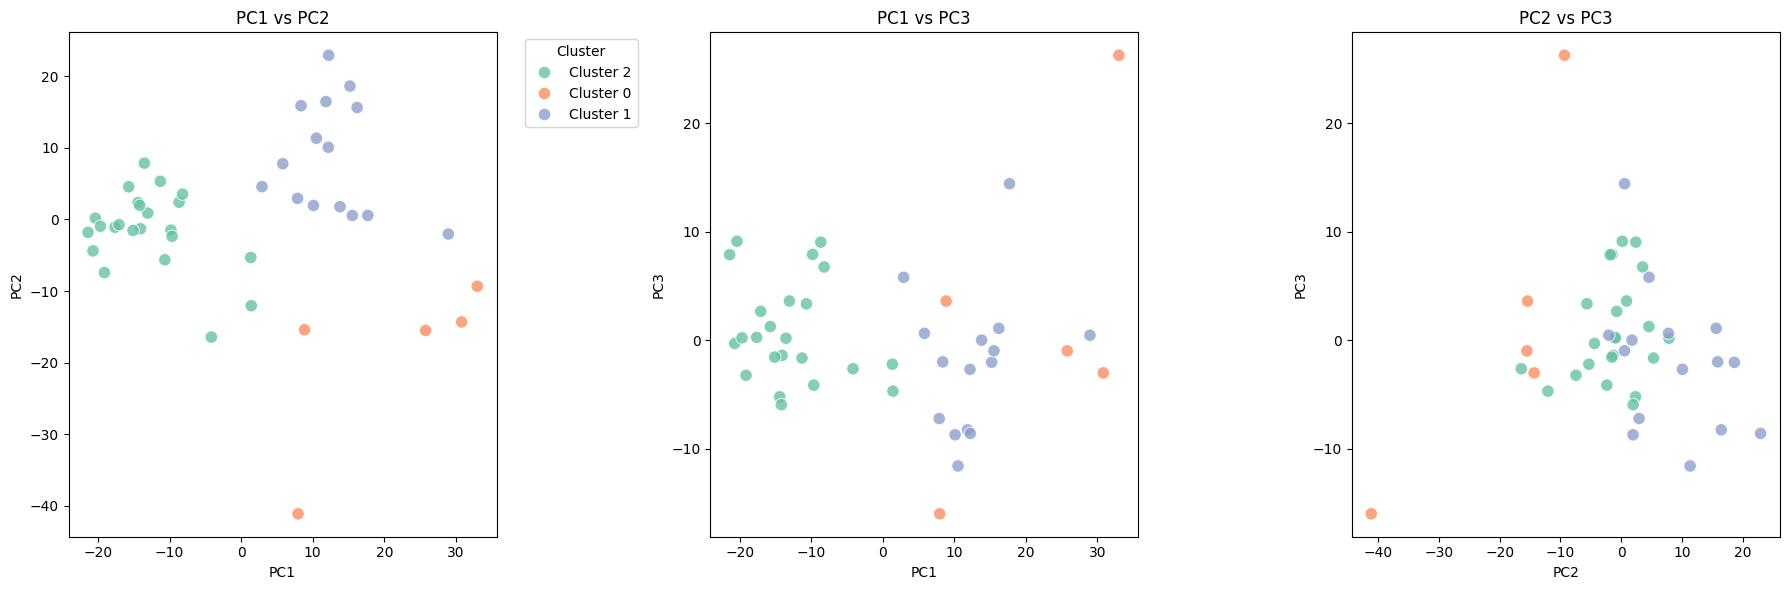

In [ ]:
# from the paper, we know we should have 3 main groups: migraine, migraine with medications, and migraine-free
kmeans = KMeans(n_clusters = 3, random_state = 42)
pca_df["Cluster"] = kmeans.fit_predict(X_pca)
pca_df["Cluster"] = "Cluster " + pca_df["Cluster"].astype(str)

fig, axes = plt.subplots(1, 3, figsize = (18, 6))
# PC1 vs PC2
sns.scatterplot(data = pca_df, x = "PC1", y = "PC2", hue = "Cluster", palette = "Set2", s = 80, alpha = 0.8, ax = axes[0])
axes[0].set_title(f"PC1 vs PC2")
axes[0].legend(title = "Cluster", bbox_to_anchor = (1, 1), loc = 'upper left')

# PC1 vs PC3
sns.scatterplot(data=pca_df, x = "PC1", y = "PC3", hue = "Cluster", palette = "Set2", s = 80, alpha = 0.8, ax = axes[1])
axes[1].set_title(f"PC1 vs PC3")
axes[1].legend().remove()

# PC2 vs PC3
sns.scatterplot(data=pca_df, x = "PC2", y = "PC3", hue = "Cluster", palette = "Set2", s = 80, alpha = 0.8, ax = axes[2])
axes[2].set_title(f"PC2 vs PC3")
axes[2].legend().remove()

plt.tight_layout()
plt.show()

The PCA plot of PC1 vs PC2 shows three distinct clusters of samples:
* the green cluster is tightly grouped on the left, so we can assume the gene expression profiles are quite similar (maybe healthy cohort)
* the blue cluster is positioned higher along PC2 and shows moderate changes in expression (so it may be interictal state)
* the orange cluster spreads more along PC1 and expression variability tends to be higher (this can represent the varied migraines among individuals in the ictal phase)

In the PC1 vs PC3 plot, the overall structure remains similar:
* the green cluster stays tightly grouped on the left
* the blue and orange clusters are more spread out, particularly along PC3.

This suggests that PC3 captures some additional differences, maybe related to individual variation during migraine episodes.

Lastly, we also did PC2 vs PC3 to see if there were any additional patterns or biases. From the last plot we see that:
* the green cluster is more scattered; however, it is centered near the origin, so it's less variable in PC2 and PC3 (so it may still be our control group)
* the blue cluster is a mainly distributed on the right and it's completely separated from the orange cluster. So, we may assume that one is a migraine-free cohort, while the orange group is the migraine cluster, since it's highly varied.

### MISSING IDs MAPPING

Now that we dropped non-explanatory genes, we will try to map the missing IDs to the MyGene dataset

In [21]:
key_columns = ['geneID', 'Description', 'geneName', 'EntrezID', 'EntrezIDs'] 
metadata = metadata.loc[mask]
missing_values = metadata[key_columns].isna().sum()
print("Number of missing values in metadata columns:\n", missing_values)

Number of missing values in metadata columns:
 geneID          0
Description    52
geneName        0
EntrezID       74
EntrezIDs      74
dtype: int64


We can see that EntrezID and EntrezIDs have 74 missing values. This may be critical when trying to do pathway analysis, thus we will try to map my genes to an external database in order to retrive the missing IDs

In [22]:
from myvariant import MyVariantInfo

metadata['geneName_clean'] = (metadata['geneName'].astype(str).str.strip().str.upper())

mv = MyVariantInfo()
queries = metadata.loc[metadata['EntrezID'].isna(), 'geneName_clean'].unique().tolist()
result = mv.querymany(queries, scopes = 'symbol', fields = 'entrezgene', species = 'human')

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
74 input query terms found no hit:	['CCL3', 'AHRR', 'FCGBP', 'KIR3DX1', 'PSMB3', 'MRC1', 'MMP28', 'CCL4', 'SCO2', 'ANKRD20A3', 'ANXA8L1


Unfortunately, after using myGene (not present here but tested on the data) and myVariant, there are still 74 missing matches. Since we could not add additional entries, this section has not been reported on the paper, but left for future work (in case we would like to try even more libraries to get matches from).

## STEP 2: GENE EXPRESSION

EXPLANATION: gene expression describes the contribution of a gene to the overall functions and phenotype of a cell. 
RNA is the primary product encoded in a gene, which is transcribed in the nucleus of a cell. A type of RNA molecules (mRNAs) are transported from the nucleus to the cytoplasm, where the mRNA is translated into proteins (the type of proteins in a cell dictate the shape, function, and phenotype of the cell). There are also mRNAs which are not translated into proteins and serve as a fundamental support for the functioning of the cell (non-coding mRNA). Quantification of how much gene expression levels deviate from a baseline gives clues about which genes are actually important for disease outcome or cell/tissue identity. 

**OVERALL, the term gene expression refers to the combined activity of protein-coding or protein non-coding products of a gene**.

In [ ]:
# we put a threhsold of 0.05 for the p-value (which is the default)
p_value = 0.05
comparisons = [('K', 'M'), ('M', 'MICT'), ('MICT', 'K')]
dds.deseq2()

Fitting size factors...
... done in 0.06 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 3.79 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 5.26 seconds.

Fitting LFCs...
... done in 2.33 seconds.

Calculating cook's distance...
... done in 0.07 seconds.

Replacing 56 outlier genes.

Fitting dispersions...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.05 seconds.



In [ ]:
def analysis(dds, group1, group2, p_value):
    # we run DEA for each tuple in the comparisons list and extract the results (+ drop the NAs)
    statistics = DeseqStats(dds, contrast = ["condition", group1, group2])
    statistics.summary()
    dea = statistics.results_df.copy()
    dea = dea.dropna(subset = ["padj"])

    # then, we filter the significant genes based on the p-value threshold (we do not use the log2 fold change)
    significant = dea[dea["padj"] < p_value]

    print(f"DEA: {group1} vs {group2}")
    print(f"Significant genes: {significant.shape[0]}")

    plt.figure(figsize=(5, 3))

    # volcano plot: all genes vs. significant ones
    plt.scatter(dea["log2FoldChange"], -np.log10(dea["padj"]), alpha = 0.6, label = "all genes")
    plt.scatter(significant["log2FoldChange"], -np.log10(significant["padj"]), color = "red", alpha = 0.8, label = f"significant (padj < {p_value})")
    plt.axhline(-np.log10(p_value), color = "blue", linestyle = "--", linewidth = 2, label = f"-log10(padj)")
    plt.xlabel("log2 fold change")
    plt.ylabel("-Log10 adjusted p-value")
    plt.title(f"volcano Plot: {group1} vs {group2}")
    plt.legend(frameon = True)
    plt.grid(True)
    plt.show()

    return dea, significant

#### RESULTS

We start from the assumption that:
* K = control group --> blood taken when the participants do not suffer from migraine
* MICT = ictal (migraine) cohort --> blood taken when the particpants were having a migraine attack
* M = interictal (migraine-free) cohort --> blood taken after the participants hadn't had a migraine attack for some days

Running Wald tests...
... done in 1.45 seconds.



Log2 fold change & Wald test p-value: condition K vs M
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0       15.726138       -0.077920  0.260483 -0.299135  0.764837  0.839771
1        0.000000             NaN       NaN       NaN       NaN       NaN
2      530.591534       -0.337591  0.104178 -3.240537  0.001193  0.007893
3      365.732040        0.072734  0.062569  1.162459  0.245049  0.378124
4       82.677715        0.213016  0.147067  1.448427  0.147498  0.258817
...           ...             ...       ...       ...       ...       ...
22620    0.000000             NaN       NaN       NaN       NaN       NaN
22621    0.000000             NaN       NaN       NaN       NaN       NaN
22622    0.000000             NaN       NaN       NaN       NaN       NaN
22623    0.000000             NaN       NaN       NaN       NaN       NaN
22624    0.000000             NaN       NaN       NaN       NaN       NaN

[22625 rows x 6 columns]
DEA: K vs M
Significant genes: 

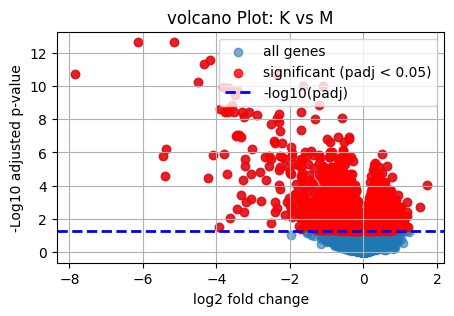

In [25]:
deaKM, genesKM = analysis(dds, "K", "M", p_value)

Running Wald tests...
... done in 1.39 seconds.



Log2 fold change & Wald test p-value: condition K vs MICT
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0       15.726138       -0.091577  0.305107 -0.300146  0.764066  0.878226
1        0.000000             NaN       NaN       NaN       NaN       NaN
2      530.591534       -0.215469  0.122871 -1.753614  0.079497  0.269610
3      365.732040        0.056660  0.073535  0.770510  0.440997  0.659747
4       82.677715        0.062967  0.172522  0.364982  0.715125  0.849397
...           ...             ...       ...       ...       ...       ...
22620    0.000000             NaN       NaN       NaN       NaN       NaN
22621    0.000000             NaN       NaN       NaN       NaN       NaN
22622    0.000000             NaN       NaN       NaN       NaN       NaN
22623    0.000000             NaN       NaN       NaN       NaN       NaN
22624    0.000000             NaN       NaN       NaN       NaN       NaN

[22625 rows x 6 columns]
DEA: K vs MICT
Significant g

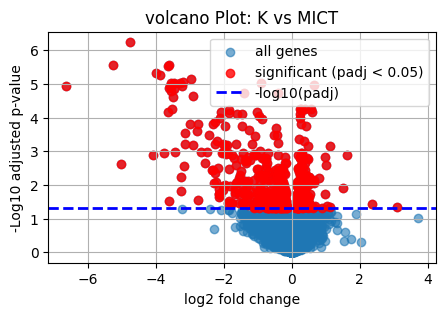

In [26]:
deaKMICT, genesKMICT = analysis(dds, "K", "MICT", p_value)

Running Wald tests...
... done in 1.46 seconds.



Log2 fold change & Wald test p-value: condition MICT vs M
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0       15.726138        0.013657  0.281059  0.048592  0.961245  0.991321
1        0.000000             NaN       NaN       NaN       NaN       NaN
2      530.591534       -0.122122  0.112959 -1.081124  0.279642  0.698047
3      365.732040        0.016074  0.068011  0.236345  0.813165  0.953744
4       82.677715        0.150048  0.159815  0.938885  0.347790  0.749709
...           ...             ...       ...       ...       ...       ...
22620    0.000000             NaN       NaN       NaN       NaN       NaN
22621    0.000000             NaN       NaN       NaN       NaN       NaN
22622    0.000000             NaN       NaN       NaN       NaN       NaN
22623    0.000000             NaN       NaN       NaN       NaN       NaN
22624    0.000000             NaN       NaN       NaN       NaN       NaN

[22625 rows x 6 columns]
DEA: MICT vs M
Significant g

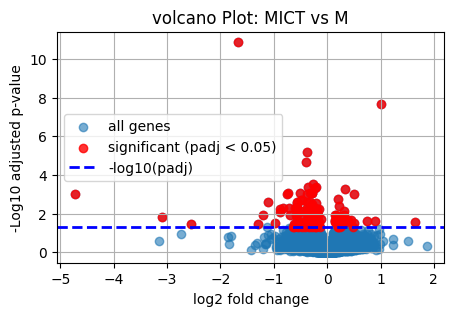

In [27]:
deaMMICT, genesMMICT = analysis(dds, "MICT", "M", p_value)

From the DEA, we inferred the following:
- K vs M shows a large cluster of points on the left, meaning many genes are still more highly expressed after treatment than in healthy controls, with only a few genes “rescued” above baseline, suggesting persistent inflammation.
- K vs MICT highlights that most significant genes lie on the left side, indicating strong up-regulation of inflammatory, neurovascular, and pain-related pathways during a migraine attack, while only a handful of genes are down-regulated.
- MICT vs M is more balanced: a substantial set of genes drops after medication (points on the left) and a smaller group is induced post‐treatment (points on the right), reflecting both suppression of the migraine response and activation of recovery or drug‐metabolism pathways.

## STEP 3: PATHWAY ANALYSIS

Enrcihment analysis is a method used to determine if a specific set of genes or pathways is over-represented in a larger list of genes. In this analysis, we are going to do GSEA (gene set enrichment analysis) and ORA (over-representation analysis).

In [29]:
GSEA = {"K_vs_M": deaKM, "K_vs_MICT": deaKMICT, "MICT_vs_M": deaMMICT}
ORA = {"K_vs_M": genesKM, "K_vs_MICT": genesKMICT, "MICT_vs_M": genesMMICT}

In [30]:
for i, j in ORA.items():
    idx = j.index.astype(int)
    gene = data.loc[idx, "geneName"]
    j.index = gene.values
    ORA[i] = j

In [ ]:
all_libs = gp.get_library_name()

for i, j in ORA.items():
    gene_list = j.index.tolist()  
    if not gene_list:
        continue

    enr = gp.enrichr(gene_list = gene_list, gene_sets = all_libs, outdir = f'enrichr_{i}', cutoff = 0.1, format = 'png', figsize = (6,4))
    print(enr.results[['Term','Adjusted P-value','Overlap']].head(5).to_string(index=False))
# we also tried with different cutoffs (ranging from 0.05 to 1.0 - not shown here, but tested) and the result is the same: no enrichment terms were found

ValueError: Warning: No enrich terms when cutoff = 0.1

In [32]:
for i, j in GSEA.items():
    idx = j.index.astype(int)
    gene = data.loc[idx, "geneName"]
    j.index = gene.values
    GSEA[i] = j

In [ ]:
good_libs = [lib for lib in all_libs if lib.startswith("GO_") or lib.startswith("KEGG_") or lib.startswith("Reactome_")]

for i, j in GSEA.items():
    prerank = j['stat'].sort_values(ascending = False)
    prerank.name = f'{i}_wald_stat'
    res = gp.prerank(rnk = prerank, gene_sets = good_libs, outdir = f'gsea_prerank_{i}_multi', permutation_num = 1000, seed = 42, no_plot = True)
    print(f"\nTop 5 pathways for {i}:")
# again, here we also tried with different cutoffs and no terms were found

2025-05-29 10:00:54,446 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


2025-05-29 10:16:14,296 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.



Top 5 pathways for K_vs_M:


2025-05-29 11:11:32,099 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.



Top 5 pathways for K_vs_MICT:

Top 5 pathways for MICT_vs_M:


Unfortunately, the above for GSEA and ORA did not produce any results. This is probably due to the library used, which may not be as updated and state-of-the-art as other R libraries that do the same job. Particularly, the cutoff threshold seems to be "useless", meaning that setting it higher or lower does not change the fact that no enrichment is found. For this reason, we wrote an R script that uses enrichrR and that script works well and produces two outputs, KEGG_enrichment.csv and GO_BP_enrichment.csv

In [ ]:
GSEA_df = pd.concat(GSEA, names = ["comparison"])
GSEA_df.reset_index(inplace = True)

ORA_df = pd.concat(ORA, names = ["comparison"])
ORA_df.reset_index(inplace = True)

In [ ]:
GSEA_df.to_csv("GSEA_results.csv", index = False)
ORA_df.to_csv("ORA_results.csv", index = False)

We will now upload the results of the R script here and proceed to process them and see the pathways important to our disease (if there are any).

In [37]:
GO_data = pd.read_csv("GO_BP_enrichment.csv")
KEGG_data = pd.read_csv("KEGG_enrichment.csv")

These files contain > 5k results, not all of them are significant. Thus, we introduce a cutoff threshold based on the p-value of 0.05. Any of the remaining pathways will be filtered for min/max hits, considered significant and will be analyzed.

In [ ]:
def filtering(data, adjp = 0.05, min_hits = 10, max_hits = 300, top = 50):
    data[['hits', 'total']] = data['Overlap'].str.split('/', expand = True).astype(int)
    data['-log10(Adj.P)'] = -np.log10(data['Adjusted.P.value'].replace(0, 1e-300))

    filtered = data[(data['Adjusted.P.value'] < adjp) & (data['hits'] >= min_hits) & (data['total'] <= max_hits)].copy()
    filtered = filtered.sort_values(by='Combined.Score', ascending=False).head(top)
    
    return filtered

filtered_go = filtering(GO_data)
filtered_kegg = filtering(KEGG_data)

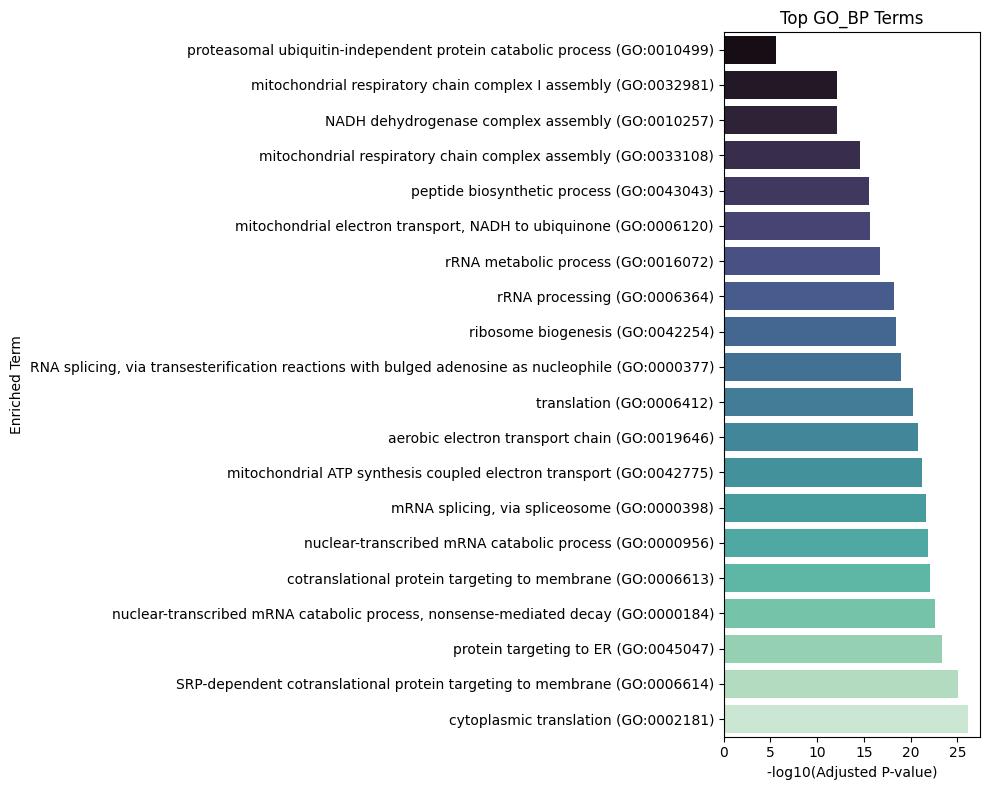

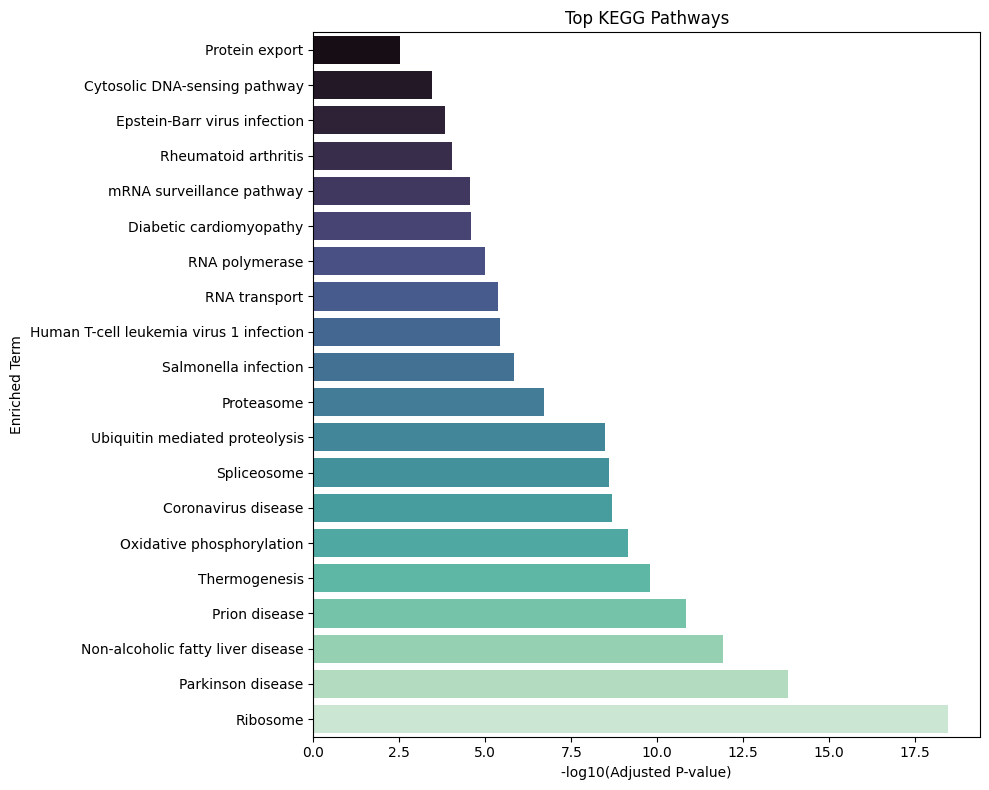

In [ ]:
def plotting(data, title, top = 20):
    data = data.head(top).sort_values('-log10(Adj.P)', ascending = True)
    plt.figure(figsize = (10, 8))
    sns.barplot(data = data, x = '-log10(Adj.P)', y = 'Term', palette = 'mako')
    plt.title(title)
    plt.xlabel('-log10(Adjusted P-value)')
    plt.ylabel('Enriched Term')
    plt.tight_layout()
    plt.show()

plotting(filtered_go, "Top GO_BP Terms")
plotting(filtered_kegg, "Top KEGG Pathways")

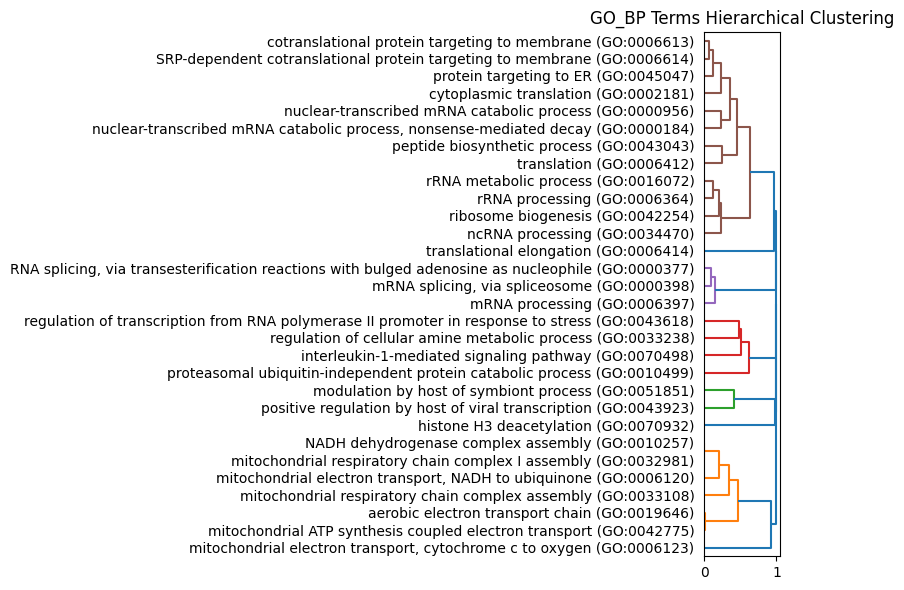

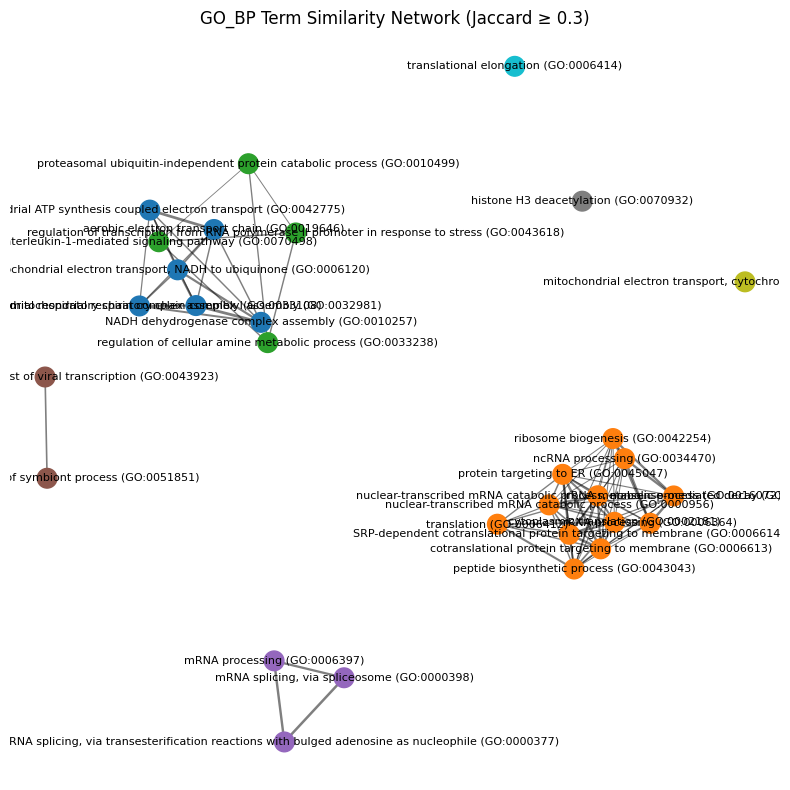

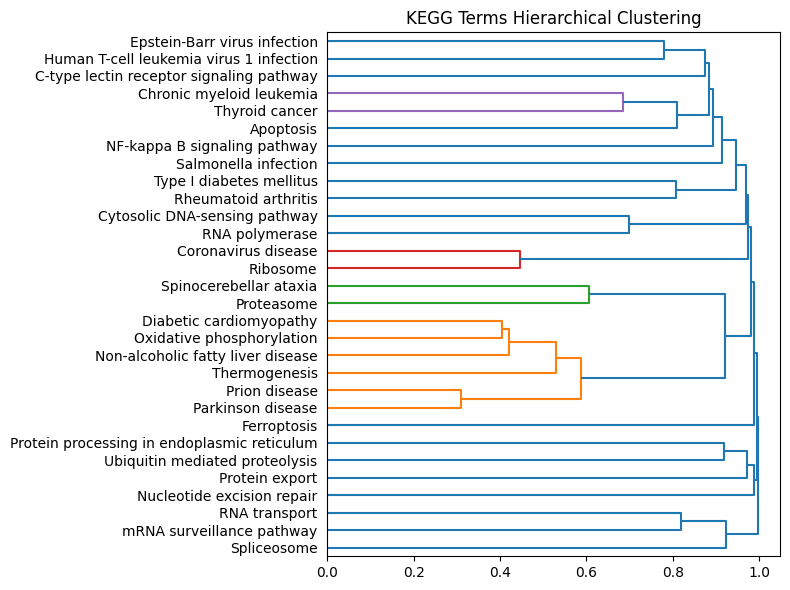

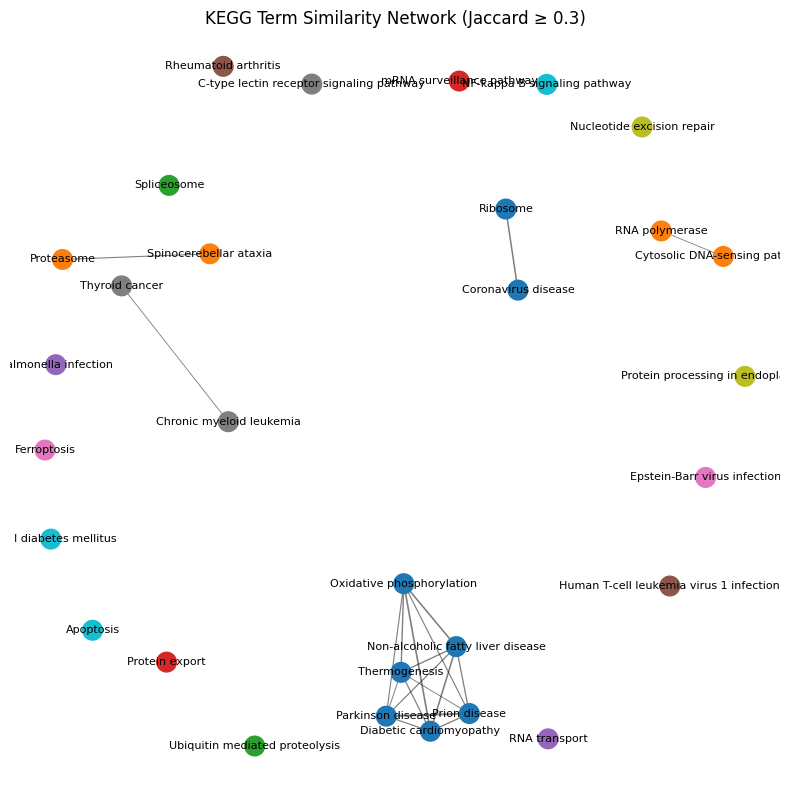

In [ ]:
# this code was written quickly mainly to visualize what was going on.
# there are some nested loops here which can be slow for large datasets. it's not our case, but it's worth noting if we'll work later on with larger datasets

def clustering(data, label, top = 30, jaccard = 0.25):
    df = data.sort_values("Combined.Score", ascending = False).head(top).copy()
    df["GeneSet"] = df["Genes"].str.split(";").apply(set)
    terms = df["Term"].tolist()
    gene_sets = df["GeneSet"].tolist()

    # here we build the matrix with Jaccard distance
    n = len(terms)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            x, y = gene_sets[i], gene_sets[j]
            d = 1 - len(x & y) / len(x | y)
            D[i, j] = D[j, i] = d
    
    condensed = squareform(D)
    linkage = hierarchy.linkage(condensed, method = "average")

    # here we plot the dendrogram
    plt.figure(figsize = (8, 6))
    hierarchy.dendrogram(linkage, labels = terms, orientation = "right", color_threshold = 0.7 * max(linkage[:, 2]))
    plt.title(f"{label} Terms hierarchical clustering")
    plt.tight_layout()
    plt.savefig(f"{label}_dendrogram.png")
    plt.show()

    # we build the similarity network
    G = nx.Graph()
    for term in terms:
        G.add_node(term)
    for i in range(n):
        for j in range(i + 1, n):
            sim = 1 - D[i, j]
            if sim >= jaccard:
                G.add_edge(terms[i], terms[j], weight = sim)

    components = list(nx.connected_components(G))
    for i, comp in enumerate(components):
        for term in comp:
            map = {term: i}
    
    colors = [map[t] for t in G.nodes()]

    # instead, here we plot the network
    plt.figure(figsize = (8, 8))
    pos = nx.spring_layout(G, seed = 42, k = 0.5)
    nx.draw_networkx_nodes(G, pos, node_size = 200, node_color = colors, cmap = plt.cm.tab10)
    nx.draw_networkx_labels(G, pos, font_size = 8)
    for u, v, d in G.edges(data = True):
        nx.draw_networkx_edges(G, pos, edgelist = [(u, v)], width = d["weight"] * 2, alpha = 0.5)
    plt.title(f"{label} term similarity network")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{label}_network.png")
    plt.show()

clustering(filtered_go, label = "GO_BP", top = 30, jaccard = 0.25)
clustering(filtered_kegg, label = "KEGG", top = 30, jaccard = 0.25)
